# DeepEM: A Deep Learning Approach for DEM Inversion
by Paul Wright$^{1}$, Mark Cheung$^{2,3}$, Rajat Thomas$^{4}$, Richard Galvez$^{5}$, Alexandre Szenicer$^{6}$, Meng Jin$^{2,7}$, Andrés Muñoz-Jaramillo$^{8}$, and David Fouhey$^{9}$


$^{1}$University of Glasgow, email: paul@pauljwright.co.uk;
$^{2}$Lockheed Martin Solar and Astrophysics Laboratory;
$^{3}$Stanford University;
$^{4}$University of Amsterdam;
$^{5}$New York University;
$^{6}$University of Oxford;
$^{7}$SETI Institute;
$^{8}$SouthWest Research Institute;
$^{9}$University of California, Berkeley 

---

The intensity observed through optically-thin <i>SDO</i>/AIA filters (94 Å, 131 Å, 171 Å, 193 Å, 211 Å, 335 Å) can be related to the temperature distribution of the solar corona (the differential emission measure; DEM) as

\begin{equation}
g_{i} = \int_{T} K_{i}(T) \xi(T) dT \, .
\end{equation}

In this equation, $g_{i}$ is the DN s$^{-1}$ px$^{-1}$ value in the $i$th SDO/AIA channel. This intensity corresponds to the $K_{i}(T)$ temperature response function, and the DEM, $\xi(T)$, is in units of cm$^{-5}$ K$^{-1}$. The matrix formulation of this integral equation can be represented in the form $\vec{g} = {\bf K}\vec{\xi}$, however this problem is an ill-posed inverse problem, and any attempt to directly recover $\vec{\xi}$ leads to significant noise amplification. 

There are numerous methods to tackle mathematical problems of this kind, and there are an increasing number of methods in the literature for recovering the differential emission measure from <i>SDO</i>/AIA observations, including methods based techniques such as Tikhonov Regularisation (<a href="https://doi.org/10.1051/0004-6361/201117576">Hannah & Kontar 2012</a>), on the concept of sparsity (<a href="https://doi.org/10.1088/0004-637X/807/2/143">Cheung <i>et al</i> 2015</a>).

In this notebook we will introduce a deep learning approach for DEM Inversion. <i>For this notebook</i>, DeepEM is a trained on one set of <i>SDO</i>/AIA observations (six optically thin channels; 6 x N x N) and DEM solutions (in 18 temperature bins from log$_{10}$T = 5.5 - 7.2, 18 x N x N; Cheung <i>et al</i> 2015) at a resolution of 512 x 512 (N = 512) using a 1x1 2D Convolutional Neural Network with a single hidden layer.

The DeepEM method presented here takes every DEM solution with no regards to the quality or existence of the solution. As will be demonstrated, when this method is trained with a single set images and DEM solutions, the DeepEM solutions have a similar fidelity to Basis Pursuit (with a significantly increased computation speed), and additionally, the DeepEM solutions find positive solutions at every pixel, and reduced noise in the DEM solutions.

In [1]:
#This notebook has been written in PyTorch
import os
import json
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#cudaize determines if a gpu is available for training and testing
def cudaize(obj):
    return obj.cuda() if torch.cuda.is_available() else obj

In [3]:
def em_scale(y):
    return np.sqrt(y/1e25)

def em_unscale(y):
    return 1e25*(y*y)

def img_scale(x):
    x2 = x
    bad = np.where(x2 <= 0.0)
    x2[bad] = 0.0
    return np.sqrt(x2)

def img_unscale(x):
    return x*x 

### Step 1: Obtain Data and Basis Pursuit Solutions for Training



We first load the <i>SDO</i>/AIA images and Basis Pursuit DEM maps.

N.B. While this simplified version of DeepEM has been trained on DEM maps from Basis Pursuit (Cheung <i>et al</i> 2015), we actively encourage the readers to try their favourite method for DEM inversion! 

In [5]:
import glob
from sunpy.io.special import read_genx
aia_files = glob.glob('./DeepEM_Data/*_2014-03-29T1[89]*genx')
aia_files = sorted(aia_files)
print(aia_files)

k = 0
for f in aia_files:
    dump = read_genx(f)
    if k == 0:
        X = np.zeros((len(aia_files), dump['IMG'].shape[0], dump['IMG'].shape[1], dump['IMG'].shape[2]))
        y = np.zeros((len(aia_files), dump['EMCUBE'].shape[0], dump['EMCUBE'].shape[1], dump['EMCUBE'].shape[2]))
        status = np.zeros((len(aia_files), dump['STATUS'].shape[0], dump['STATUS'].shape[1]))
        lgtaxis = dump['LGTAXIS']
        nlgT = lgtaxis.shape[0]
        
    X[k] = dump['IMG']
    y[k] = dump['EMCUBE']
    status[k] = dump['STATUS']
    k = k+1

# Scale the inputs and outputs
X = img_scale(X)
y = em_scale(y)

['./DeepEM_Data/ar12017_tolfunc_5.500_solution_2014-03-29T18:24.genx', './DeepEM_Data/ar12017_tolfunc_5.500_solution_2014-03-29T18:44.genx', './DeepEM_Data/ar12017_tolfunc_5.500_solution_2014-03-29T19:04.genx']


### Step 2: Define the Model

We first define the model as a 1x1 2D Convolutional Neural Network (CNN) with a kernel size of 1x1 and a single hidden layer. The model accepts a data cube of 6 x N x N (<i>SDO</i>/AIA data), and returns a data cube of 18 x N x N (DEM). When trained, this will transform the input (each pixel of the 6 <i>SDO</i>/AIA channels; 6 x 1 x 1) to the output (DEM at each pixel; 18 x 1 x 1).

In [6]:
model = nn.Sequential(
    nn.Conv2d(6, 300, kernel_size=1),
    nn.LeakyReLU(), 
    nn.Conv2d(300, 300, kernel_size=1),
    nn.LeakyReLU(),
    nn.Conv2d(300, nlgT, kernel_size=1))

model = cudaize(model)

### Step 3: Train the Model

For training, we select one <i>SDO</i>/AIA data cube (6 x 512 x 512) and the corresponding Basis Pursuit DEM output (18 x 512 x 512). In the case presented here, we train the CNN on an image of the Sun obtained on the 27 Jan  2011; validate on an image of the Sun obtained one synodic rotation later (+26 days; 22-02-2011); and finally test on an image another 26 days later (20-03-2011).

In [7]:
X_train = X[0:1] 
y_train = y[0:1] 

X_val = X[1:2] 
y_val = y[1:2] 

X_test = X[2:3] 
y_test = y[2:3]

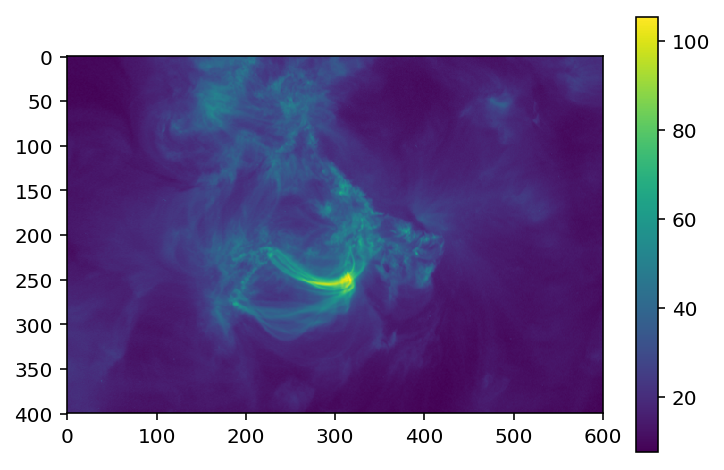

In [8]:
plt.imshow(X_test[0,3,:,:])
plt.colorbar()

#### Plotting SDO/AIA Observations ${\it vs.}$ Basis Pursuit DEM bins

For the test data set, the <i>SDO</i>/AIA images for 171 Å, 211 Å, and 94 Å, and the corresponding DEM bins near the peak sensitivity in these relative isothermal channel (log$_{10}$T = 5.9, 6.3, 7.0) are shown in Figure 1. Figure 1 shows a set of <i>SDO</i>/AIA images (171 Å, 211 Å, and 94 Å [top, left to right]) with the corresponding DEM maps (bottom) for temperature bins there are near the peak sensitivity of the <i>SDO</i>/AIA channel. Furthermore, it is clear from the DEM maps that a number of pixels that are $zero$. These pixels are primarily located off-disk, but there are a number of pixels on-disk that show this behaviour.

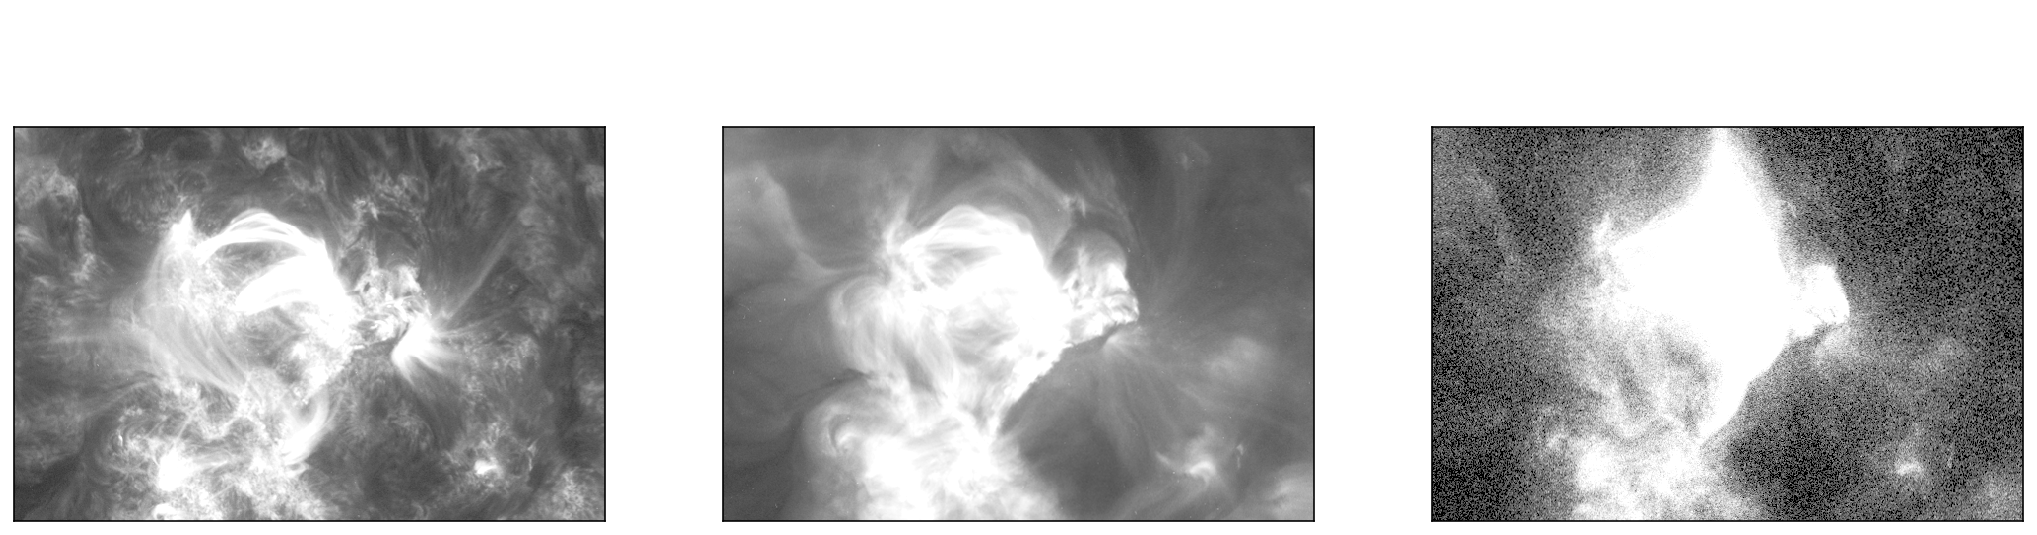

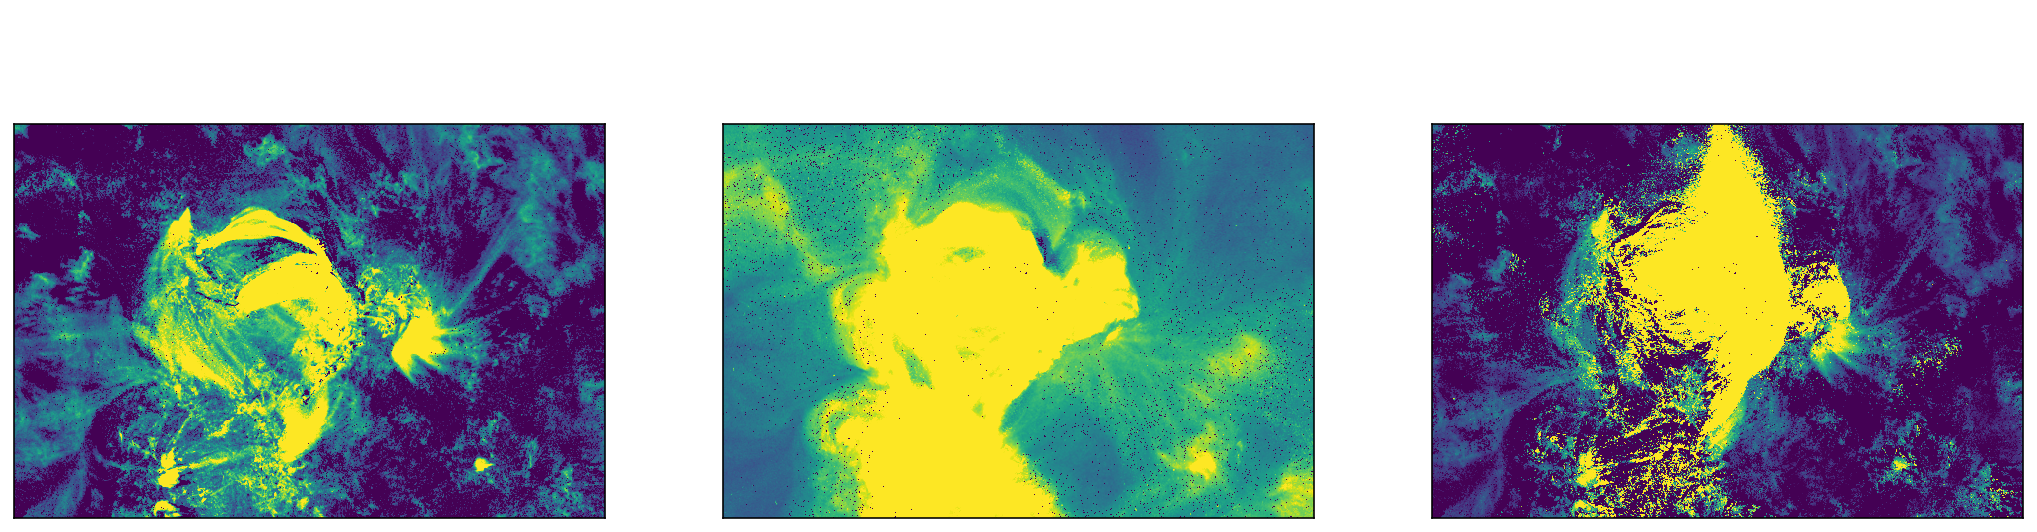

In [9]:
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r', origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 171 $\AA$', color="white", size='large')
ax[1].imshow(X_test[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r', origin='lower')
ax[1].text(5, 490, '${\it SDO}$/AIA 211 $\AA$', color="white", size='large')
ax[2].imshow(X_test[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r', origin='lower')
ax[2].text(5, 490, '${\it SDO}$/AIA 94 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(y_test[0,4,:,:],vmin=0.01,vmax=3,cmap='viridis', origin='lower')
ax[0].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 5.9', color="white", size='large')
ax[1].imshow(y_test[0,8,:,:],vmin=0.25,vmax=10,cmap='viridis', origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 6.3', color="white", size='large')
ax[2].imshow(y_test[0,15,:,:],vmin=0.01,vmax=3,cmap='viridis', origin='lower')
ax[2].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 7.0', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure 1:</b> Left to Right: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (top, left to right), with the corresponding DEM bins (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown below. In the DEM bins (bottom) it is clear that there are some pixels that have solutions of DEM = $zero$, as explicitly seen as dark regions/clusters of pixels on and off disk.

---

To implement training and testing of our model, we first define a DEMdata class, and define functions for training and validation/test: train_model, and valtest_model. 

N.B. It is not necessary to train the model, and if required, the trained model can be loaded to the cpu as follows:

```python
model = nn.Sequential(
    nn.Conv2d(6, 300, kernel_size=1),
    nn.LeakyReLU(),
    nn.Conv2d(300, 300, kernel_size=1),
    nn.LeakyReLU(),
    nn.Conv2d(300, nlgT, kernel_size=1))

dem_model_file = 'DeepEM_CNN_HelioML.pth'
model.load_state_dict(torch.load(dem_model_file))

model = cudaize(model)
```

In [10]:
class DEMdata(nn.Module):
    def __init__(self, xtrain, ytrain, xtest, ytest, xval, yval, split='train'):
        
        if split == 'train':
            self.x = xtrain
            self.y = ytrain
        if split == 'val':
            self.x = xval
            self.y = yval
        if split == 'test':
            self.x = xtest
            self.y = ytest
            
    def __getitem__(self, index):
        return torch.from_numpy(self.x[index]).type(torch.FloatTensor), torch.from_numpy(self.y[index]).type(torch.FloatTensor)

    def __len__(self):
        return self.x.shape[0]

In [11]:
def train_model(dem_loader, criterion, optimizer, epochs=500):
    model.train()
    train_loss_all_batches = []
    train_loss_epoch = []
    train_val = []
    for k in range(epochs):
        count_ = 0
        avg_loss = 0
        # =================== progress indicator ==============
        if k % ((epochs + 1) // 4) == 0:
            print('[{0}]: {1:.1f}% complete: '.format(k, k / epochs * 100))
        # =====================================================
        for img, dem in dem_loader:
            count_ += 1
            optimizer.zero_grad()
            # =================== forward =====================
            img = cudaize(img)
            dem = cudaize(dem)

            output = model(img)
            loss = criterion(output, dem)

            loss.backward()
            optimizer.step()
            
            train_loss_all_batches.append(loss.item())
            avg_loss += loss.item()
        # =================== Validation ===================
        dem_data_val = DEMdata(X_train, y_train, X_test, y_test, X_val, y_val, split='val')
        dem_loader_val = DataLoader(dem_data_val, batch_size=1)
        val_loss, dummy, dem_pred_val, dem_in_test_val = valtest_model(dem_loader_val, criterion)
        
        train_loss_epoch.append(avg_loss/count_)
        train_val.append(val_loss)
        
        if k%10 == 0: 
            print('Epoch: ', k, 'trn_loss: ', avg_loss/count_, 'val_loss: ', train_val[k])
            
    torch.save(model.state_dict(), 'DeepEM_CNN_HelioML.pth')
    return train_loss_epoch, train_val

def valtest_model(dem_loader, criterion):

    model.eval()
    
    val_loss = 0
    count = 0
    test_loss = []
    for img, dem in dem_loader:
        count += 1
        # =================== forward =====================
        img = cudaize(img)
        dem = cudaize(dem)
        
        output = model(img)
        loss = criterion(output, dem)
        test_loss.append(loss.item())
        val_loss += loss.item()
        
    return val_loss/count, test_loss, output, dem

We chose the Adam optimiser with a learning rate of 1e-4, and weight_decay set to 1e-9. We use Mean Squared Error (MSE) between the Basis Pursuit DEM map and the DeepEM map as our loss function.

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-9); 
criterion = cudaize(nn.MSELoss())

Using the defined functions, `dem_data` will return the training data, and this will be loaded by the `DataLoader` with batch_size=1 (one 512 x 512 image per batch). For each epoch, `train_loss` and `valdn_loss` will be returned by `train_model`.

In [13]:
dem_data = DEMdata(X_train, y_train, X_test, y_test, X_val, y_val, split='train')
dem_loader = DataLoader(dem_data, batch_size=1)

t0=time.time() #Timing how long it takes to predict the DEMs
train_loss, valdn_loss = train_model(dem_loader, criterion, optimizer, epochs=500)
ttime = "Training time = {0} seconds".format(time.time()-t0)
print(ttime)

[0]: 0.0% complete: 
Epoch:  0 trn_loss:  38.47089385986328 val_loss:  29.8380069732666
Epoch:  10 trn_loss:  28.174381256103516 val_loss:  20.421751022338867
Epoch:  20 trn_loss:  21.690370559692383 val_loss:  14.830076217651367
Epoch:  30 trn_loss:  18.508869171142578 val_loss:  12.379322052001953
Epoch:  40 trn_loss:  17.415983200073242 val_loss:  11.764220237731934
Epoch:  50 trn_loss:  16.8887882232666 val_loss:  11.506102561950684
Epoch:  60 trn_loss:  16.23898696899414 val_loss:  11.103240013122559
Epoch:  70 trn_loss:  15.589517593383789 val_loss:  10.724630355834961
Epoch:  80 trn_loss:  14.895282745361328 val_loss:  10.312969207763672
Epoch:  90 trn_loss:  14.133744239807129 val_loss:  9.874838829040527
Epoch:  100 trn_loss:  13.325665473937988 val_loss:  9.409409523010254
Epoch:  110 trn_loss:  12.424942016601562 val_loss:  8.8904447555542
Epoch:  120 trn_loss:  11.425483703613281 val_loss:  8.300260543823242
[125]: 25.0% complete: 
Epoch:  130 trn_loss:  10.409080505371094 

In [14]:
#dem_model_file = 'DeepEM/DeepEM_trained.torch'
#model.load_state_dict(torch.load(dem_model_file))
#model = model.float()

model_np = {}
for k, v in zip(model.state_dict().keys(),model.state_dict().values()):
    model_np[k] = v.numpy()
model_np['lgtaxis'] = lgtaxis
np.save('./DeepEM_trained_ar12017.npy', [model_np])


#### Plotting: MSE Loss for Training and Validation 

In order to understand how well the model has trained we plot the training loss and validation loss as a function of Epoch in Figure 2. Figure 2 shows the MSE loss for training (blue) and validation (orange) as a function of epoch.

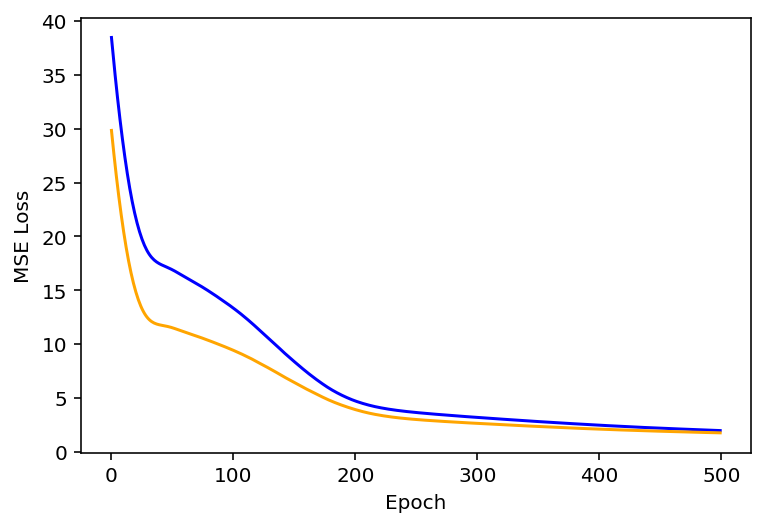

In [15]:
plt.plot(np.arange(len(train_loss)), train_loss, color="blue")
plt.plot(np.arange(len(train_loss)), valdn_loss, color="orange")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

<b>Figure 2:</b> Training and Validation MSE loss (blue, orange) as a function of Epoch.

---

### Step 4: Testing the Model

Now that the model has been trained, testing the model is a computationally cheap proceedure. As before, we choose the data using DEMdata, and load with DataLoader. Using `valtest_model`, the DeepEM map is created, and the MSE loss calculated as during training.

In [16]:
dem_data_test = DEMdata(X_train, y_train, X_test, y_test, X_val, y_val, split='test')
dem_loader = DataLoader(dem_data_test, batch_size=1)

In [17]:
t0=time.time() #Timing how long it takes to predict the DEMs
dummy, test_loss, dem_pred, dem_in_test = valtest_model(dem_loader, criterion)
performance = "Number of DEM solutions per second = {0}".format((y_test.shape[2]*y_test.shape[3])/(time.time()-t0))

In [18]:
print(performance)

Number of DEM solutions per second = 193536.7010744146


#### Plotting: AIA, Basis Pursuit, DeepEM 

With the DeepEM map calculated, we can now compare the solutions obtained by Basis Pursuit and DeepEM. Figure 3 is similar to Figure 1 with an additional row corresponding to the solutions for DeepEM. Figure 3 shows <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom), with the corresponding DEM bins from Basis Pursuit (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown in the middle (top to bottom). The right-hand column row shows the DeepEM solutions that correspond to the same bins as the Basis Pursuit solutions. DeepEM provides solutions that are similar to Basis Pursuit, but importantly, provides DEM solutions for every pixel.

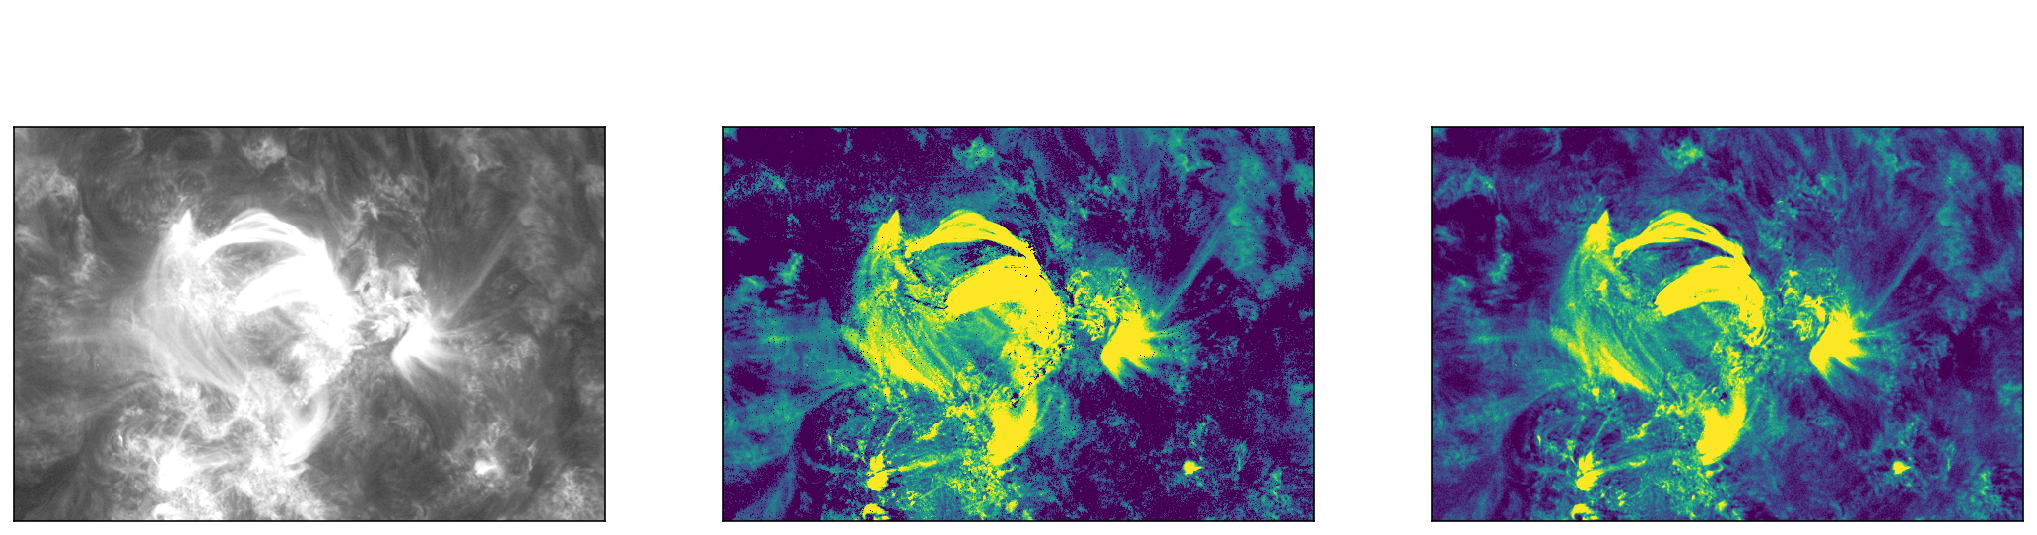

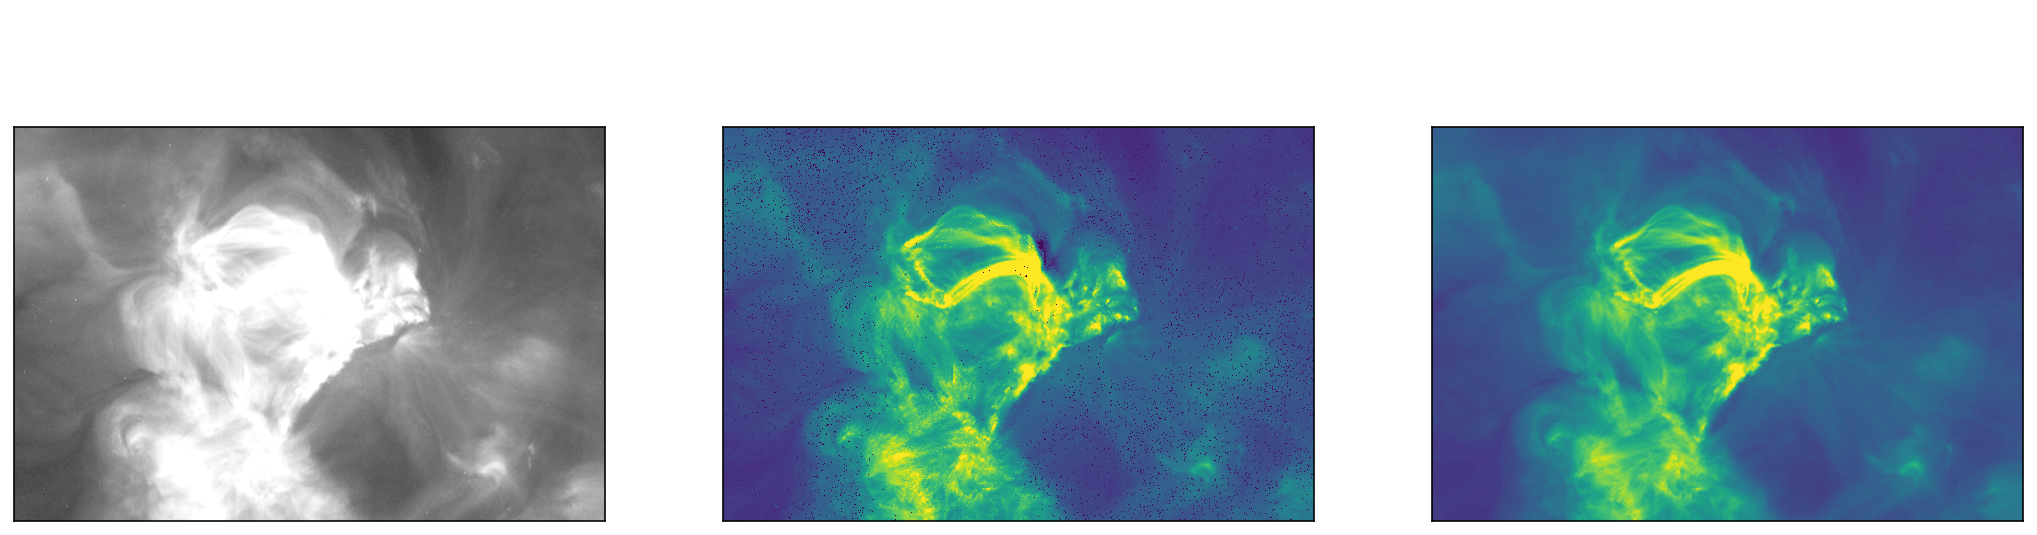

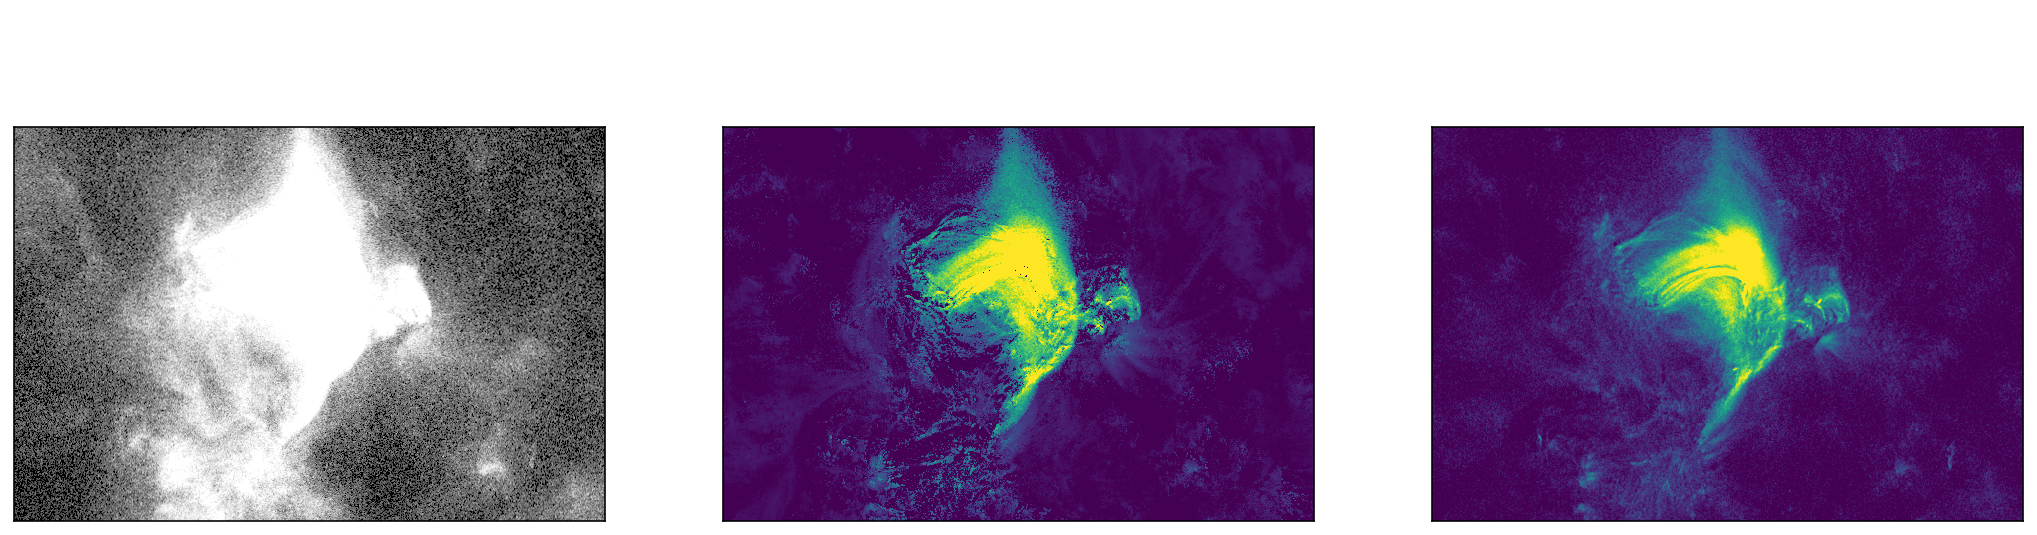

In [19]:
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 171 $\AA$', color="white", size='large')
ax[1].imshow(dem_in_test[0,4,:,:].cpu().detach().numpy(),vmin=0.01,vmax=3,cmap='viridis',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 5.9', color="white", size='large')
ax[2].imshow(dem_pred[0,4,:,:].cpu().detach().numpy(),vmin=0.01,vmax=3,cmap='viridis',origin='lower')
ax[2].text(5, 490, 'DeepEM log$_{10}$T ~ 5.9', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 211 $\AA$', color="white", size='large')
ax[1].imshow(dem_in_test[0,8,:,:].cpu().detach().numpy(),vmin=0.25,vmax=20,cmap='viridis',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 6.3', color="white", size='large')
ax[2].imshow(dem_pred[0,8,:,:].cpu().detach().numpy(),vmin=0.25,vmax=20,cmap='viridis',origin='lower')
ax[2].text(5, 490, 'DeepEM log$_{10}$T ~ 6.3', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 94 $\AA$', color="white", size='large')
ax[1].imshow(dem_in_test[0,15,:,:].cpu().detach().numpy(),vmin=0.01,vmax=15,cmap='viridis',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 7.0', color="white", size='large')
ax[2].imshow(dem_pred[0,15,:,:].cpu().detach().numpy(),vmin=0.01,vmax=15,cmap='viridis',origin='lower')
ax[2].text(5, 490, 'DeepEM log$_{10}$T ~ 7.0', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure 3</b>: Left to Right: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom), with the corresponding DEM bins from Basis Pursuit (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown below (middle, top to bottom). The right-hand column shows the DeepEM solutions that correspond to the same bins as the Basis Pursuit solutions. DeepEM provides solutions that are similar to Basis Pursuit, but importantly, provides DEM solutions for every pixel.



---

Furthermore, as we have the original Basis Pursuit DEM solutions ("the ground truth"), we can compare the average DEM from Basis Pursuit to the average DEM from DeepEM, as they should be similar. Figure 4 shows the average Basis Pursuit DEM (black curve) and the DeepEM solution (dashed line).

In [20]:
def PlotTotalEM(em_unscaled, em_pred_unscaled, lgtaxis, status):
    mask = np.zeros([status.shape[-2],status.shape[-1]])
    #mask[np.where(status == 0.0)] = 1.0
    mask[:] =1
    nmask = np.sum(mask)
    
    EM_tru_sum = np.zeros([lgtaxis.size])
    EM_inv_sum = np.zeros([lgtaxis.size])
    
    for i in range(lgtaxis.size):
        EM_tru_sum[i] = np.sum(em_unscaled[0,i,:,:]*mask)/nmask
        EM_inv_sum[i] = np.sum(em_pred_unscaled[0,i,:,:]*mask)/nmask
        
    fig = plt.figure   
    plt.plot(lgtaxis,EM_tru_sum, linewidth=3, color="black")
    plt.plot(lgtaxis,EM_inv_sum, linewidth=3, color="lightblue", linestyle='--')
    plt.tick_params(axis='both', which='major')#, labelsize=16)
    plt.tick_params(axis='both', which='minor')#, labelsize=16)
    
    dlogT = lgtaxis[1]-lgtaxis[0]
    
    plt.xlim(lgtaxis[0]-0.5*dlogT, lgtaxis.max()+0.5*dlogT)
    plt.xticks(np.arange(np.min(lgtaxis), np.max(lgtaxis),2*dlogT))
    plt.ylim(1e24,5e27)
    plt.yscale('log')
    plt.xlabel('log$_{10}$T [K]')
    plt.ylabel('Mean Emission Measure [cm$^{-5}$]')
    
    plt.show()
    return EM_inv_sum, EM_tru_sum

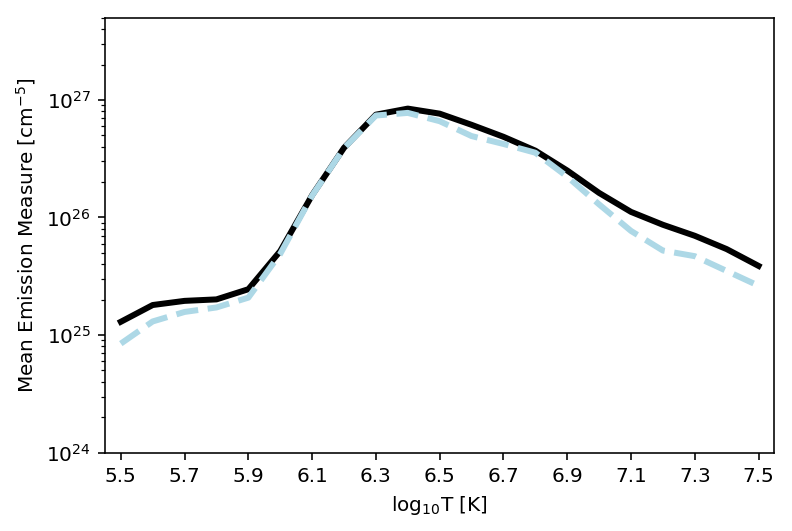

In [22]:
em_unscaled = em_unscale(dem_in_test.detach().cpu().numpy())
em_pred_unscaled = em_unscale(dem_pred.detach().cpu().numpy())

# Status for the test data. While DeepEM was trained on all examples in the training set, 
# we only compare the DEMs where Basis Pursuit obtained a solution (status = 0)
#status = status[2,:,:]

EMinv, EMTru = PlotTotalEM(em_unscaled,em_pred_unscaled,lgtaxis,status)

<b>Figure 4</b>: Average Basis Pursuit DEM (plotted as mean emission measure, black line) and the Average DeepEM solution (dashed line). It is clear that this simple implementation of DeepEM provides, on average, DEMs that are similar to Basis Pursuit (Cheung <i>et al</i> 2015).

---

### Step 5: Synthesize <i>SDO</i>/AIA Observations

Finally, it is also of interest to reconstruct the <i>SDO</i>/AIA observations from both the Basis Pursuit, and DeepEM solutions. 

We are able to pose the problem of reconstructing the <i>SDO</i>/AIA observations from the DEM as a 1x1 2D Convolution. We first define the weights as the response functions of each channel, and set the biases to $zero$. By convolving the unscaled DEM at each pixel with the 6 filters (one for each <i>SDO</i>/AIA response function), we can recover the <i>SDO</i>/AIA observations.

### Below this doesn't work since AIA_Resp.npy has the wrong number of elements in lgT

In [23]:
# We first load the AIA response functions:
cl = np.load('./DeepEM_Data/AIA_Resp.npy')


(6, 18, 1, 1)

In [24]:
# Used Conv2d to convolve?? every pixel (18x1x1) by the 6 response functions
# to return a set of observed fluxes in each channel (6x1x1)
dem2aia = cudaize(nn.Conv2d(nlgT, 6, kernel_size=1))

chianti_lines_2 = cudaize(torch.zeros(6,nlgT,1,1))
biases = cudaize(torch.zeros(6))

# set the weights to each of the SDO/AIA response functions and biases to zero
for i, p in enumerate(dem2aia.parameters()):
    if i == 0:
        p.data = Variable(cudaize(torch.from_numpy(cl).type(torch.FloatTensor)))
    else:
        p.data = biases 

In [109]:
AIA_out = img_scale(dem2aia(Variable(em_unscale(dem_in_test))).detach().cpu().numpy())
AIA_out_DeepEM = img_scale(dem2aia(Variable(em_unscale(dem_pred))).detach().cpu().numpy())

RuntimeError: Given groups=1, weight of size 6 18 1 1, expected input[1, 21, 400, 600] to have 18 channels, but got 21 channels instead

#### Plotting SDO/AIA Observations and Synthetic Observations

NameError: name 'AIA_out' is not defined

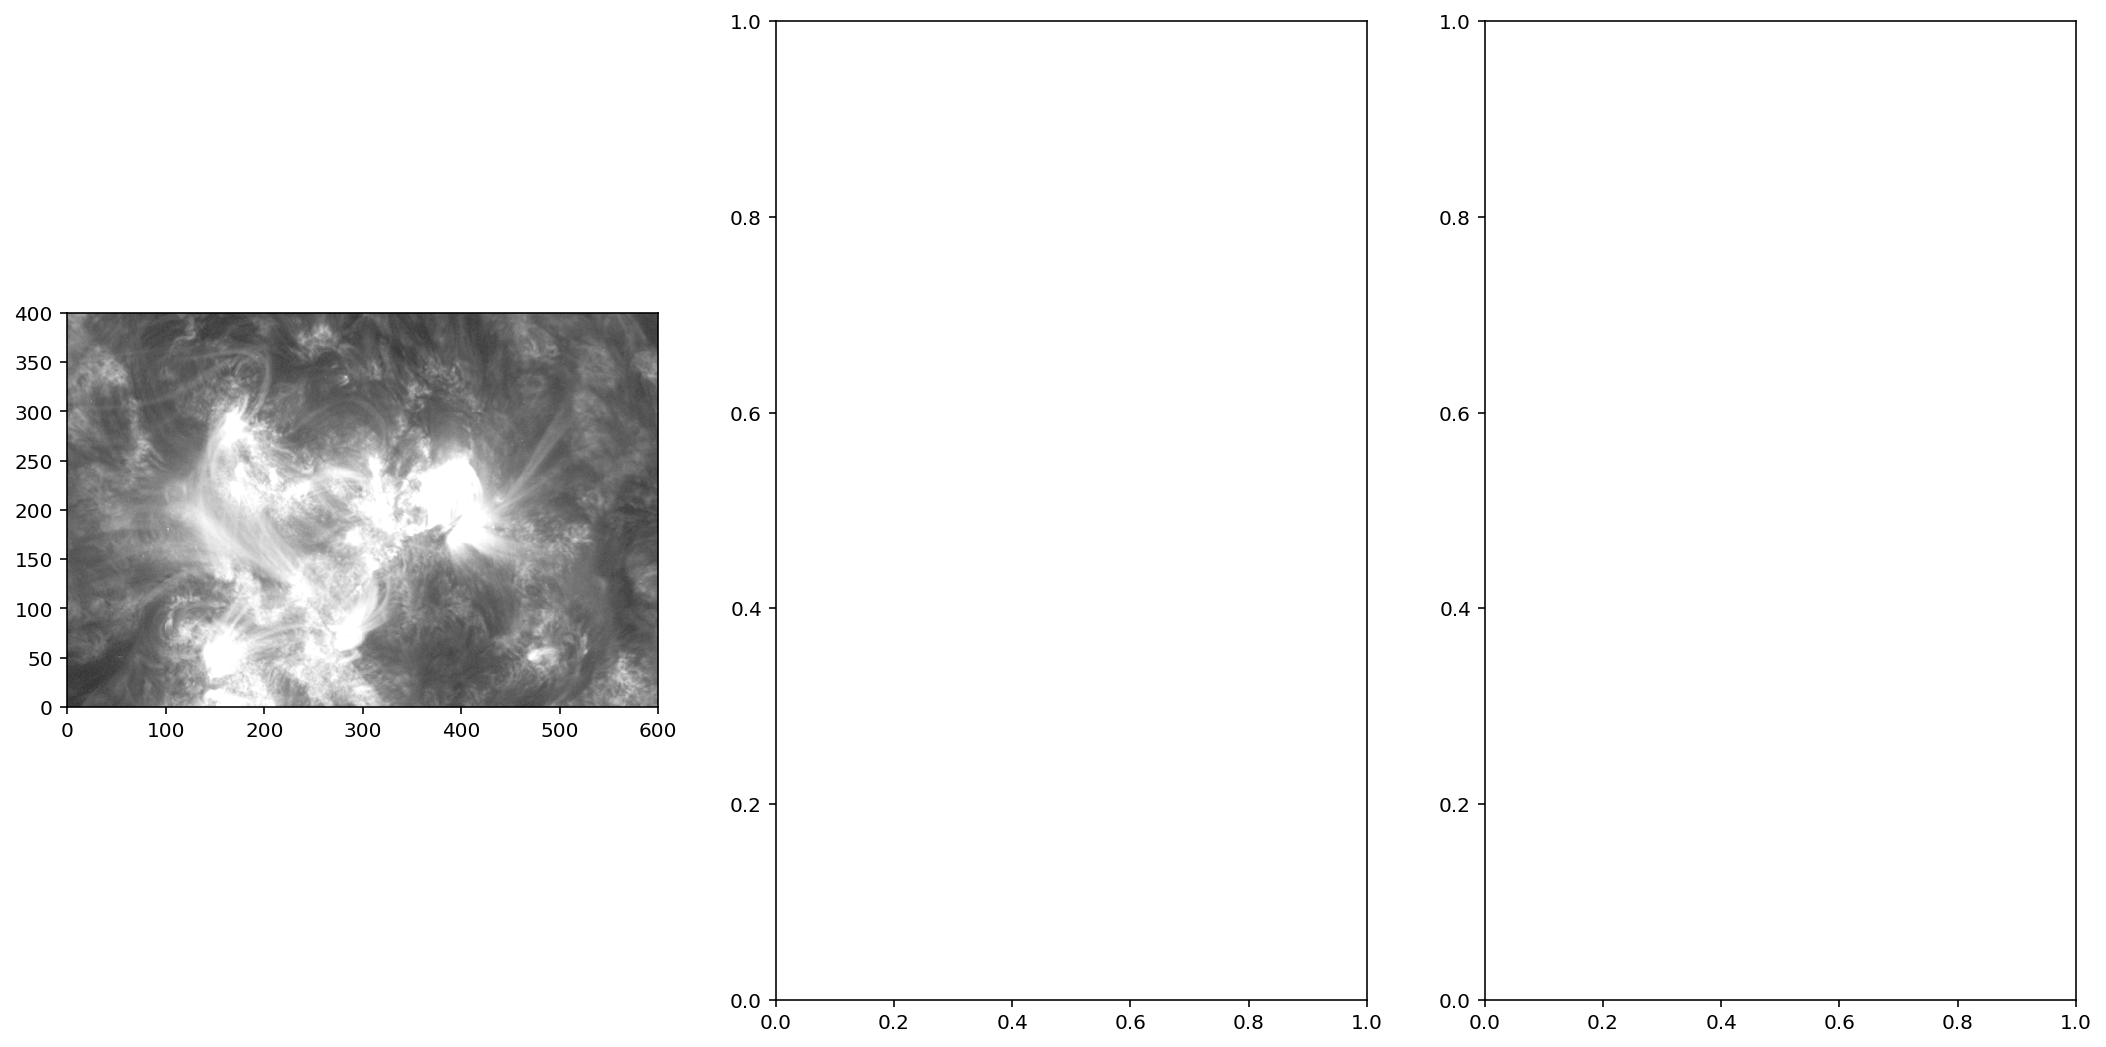

In [82]:
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 171 $\AA$', color="white", size='large')
ax[1].imshow(AIA_out[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit Synthesized 171 $\AA$', color="white", size='large')
ax[2].imshow(AIA_out_DeepEM[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[2].text(5, 490, 'DeepEM Synthesized 171 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 211 $\AA$', color="white", size='large')
ax[1].imshow(AIA_out[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit Synthesized 211 $\AA$', color="white", size='large')
ax[2].imshow(AIA_out_DeepEM[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[2].text(5, 490, 'DeepEM Synthesized 211 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 94 $\AA$', color="white", size='large')
ax[1].imshow(AIA_out[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit Synthesized 94 $\AA$', color="white", size='large')
ax[2].imshow(AIA_out_DeepEM[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[2].text(5, 490, 'DeepEM Synthesized 94 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False) 

<b>Figure 5:</b> Top to Bottom: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom) with the corresponding synthesised observations from Basis Pursuit (middle, top to bottom) and DeepEM (right, top to bottom). DeepEM provides synthetic observations that are similar to Basis Pursuit, with the addition of solutions where the basis pursuit solution was $zero$.

---

### Doing this on your data

There are two way in which you can use this notebook:

1. Train your own model: Instead of Basis Pursuit solutions (as used here), you could use your favourite inversion technique to generate the training data and then feed that into the training.

2. Directly used the pre-trained model we provide and perform inference on your AIA images.

#### Formats:

* Input: 6 x N x N (where 6 is the number of input AIA/SDO channels) as .npy file
* Output: Nt x N x N (where Nt is the number of temperature bins, 18 in our case)

where N is the dimension of the image.

#### CAUTION:
Training your model on a CPU might long!
Inference on the other hand is fast.

### Discussion

This chapter has provided a simple example of how a 1x1 2D Convolutional Neural Network can be used to improve computational cost for DEM inversion. Future development of DeepEM is on-going, and this notebook can be improved in a few ways:

1. By using both the original, and synthesised data from the DEM, the ability of the DEM to recover the original or supplementary data (such as spectroscopic EUV data) can be used as an additional term in the loss function. 

2. This implementation of DeepEM has been trained on a <i>single</i> set of observations. While there are 512$^{2}$ DEMs in one set of observations, it would be advisable to train the model to further images of the Sun in various states of activity including times of solar flaring.

3. For simplicity this implementation of DeepEM has been trained on every single pixel in the training set with no with no regards to the quality or existence of the solution. If trained for enough Epochs, DeepEM will start to remember which combinations of AIA values lead to DEMs equal to zero in the original training set. By utilising the status files included in this notebook it would be advisable to only train DeepEM on pixels where the solutions exist.

---

### Appendix A: What has the CNN learned about our training set?

If we say that our training set is now our test set, we can see how much the CNN has learned about the training data.

In [ ]:
X_test = X_train 
y_test = y_train

In [ ]:
dem_data_test = DEMdata(X_train, y_train, X_test, y_test, X_val, y_val, split='test')
dem_loader = DataLoader(dem_data_test, batch_size=1)

dummy, test_loss, dem_pred_trn, dem_in_test_trn = valtest_model(dem_loader, criterion)

In [ ]:
AIA_out = img_scale(dem2aia(Variable(em_unscale(dem_in_test_trn))).detach().cpu().numpy())
AIA_out_DeepEM = img_scale(dem2aia(Variable(em_unscale(dem_pred_trn))).detach().cpu().numpy())

In [ ]:
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))


ax[0].imshow(X_test[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 171 $\AA$', color="white", size='large')
ax[1].imshow(dem_in_test_trn[0,4,:,:].cpu().detach().numpy(),vmin=0.01,vmax=3,cmap='viridis',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 5.9', color="white", size='large')
ax[2].imshow(dem_pred_trn[0,4,:,:].cpu().detach().numpy(),vmin=0.01,vmax=3,cmap='viridis',origin='lower')
ax[2].text(5, 490, 'DeepEM log$_{10}$T ~ 5.9', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 211 $\AA$', color="white", size='large')
ax[1].imshow(dem_in_test_trn[0,8,:,:].cpu().detach().numpy(),vmin=0.25,vmax=10,cmap='viridis',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 6.3', color="white", size='large')
ax[2].imshow(dem_pred_trn[0,8,:,:].cpu().detach().numpy(),vmin=0.25,vmax=10,cmap='viridis',origin='lower')
ax[2].text(5, 490, 'DeepEM log$_{10}$T ~ 6.3', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 94 $\AA$', color="white", size='large')
ax[1].imshow(dem_in_test_trn[0,15,:,:].cpu().detach().numpy(),vmin=0.01,vmax=3,cmap='viridis',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit DEM log$_{10}$T ~ 7.0', color="white", size='large')
ax[2].imshow(dem_pred_trn[0,15,:,:].cpu().detach().numpy(),vmin=0.01,vmax=3,cmap='viridis',origin='lower')
ax[2].text(5, 490, 'DeepEM log$_{10}$T ~ 7.0', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure A1</b>: Left to Right: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom) for the training set, with the corresponding DEM bins from Basis Pursuit (chosen at the peak sensitivity of each of the <i>SDO</i>/AIA channels) shown below (middle, top to bottom). The right-hand column shows the DeepEM solutions that correspond to the same bins as the Basis Pursuit solutions. DeepEM provides solutions that are similar to Basis Pursuit, but importantly, provides DEM solutions for every pixel.



What this shows is that even in training the model has not learned the exact mapping from specific <i>SDO</i>/AIA observations to DEMs, and there is sufficient generalisation that the $zero$ DEMs are not learned by the model. 

Finally, we can synthesise the <i>SDO</i>/AIA observations, as previously.

In [ ]:
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 171 $\AA$', color="white", size='large')
ax[1].imshow(AIA_out[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit Synthesized 171 $\AA$', color="white", size='large')
ax[2].imshow(AIA_out_DeepEM[0,2,:,:],vmin=0.01,vmax=30,cmap='Greys_r',origin='lower')
ax[2].text(5, 490, 'DeepEM Synthesized 171 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 211 $\AA$', color="white", size='large')
ax[1].imshow(AIA_out[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit Synthesized 211 $\AA$', color="white", size='large')
ax[2].imshow(AIA_out_DeepEM[0,4,:,:],vmin=0.25,vmax=25,cmap='Greys_r',origin='lower')
ax[2].text(5, 490, 'DeepEM Synthesized 211 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
fig,ax=plt.subplots(ncols=3,figsize=(9*2,9))

ax[0].imshow(X_test[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[0].text(5, 490, '${\it SDO}$/AIA 94 $\AA$', color="white", size='large')
ax[1].imshow(AIA_out[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[1].text(5, 490, 'Basis Pursuit Synthesized 94 $\AA$', color="white", size='large')
ax[2].imshow(AIA_out_DeepEM[0,0,:,:],vmin=0.01,vmax=3,cmap='Greys_r',origin='lower')
ax[2].text(5, 490, 'DeepEM Synthesized 94 $\AA$', color="white", size='large')

for axes in ax:
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

<b>Figure A2:</b> Top to Bottom: <i>SDO</i>/AIA images in 171 Å, 211 Å, and 94 Å (left, top to bottom) with the corresponding synthesised observations from Basis Pursuit (middle, top to bottom) and DeepEM (right, top to bottom). DeepEM provides synthetic observations that are similar to Basis Pursuit, with the addition of solutions where the basis pursuit solution was $zero$.

---

In [42]:
torch.save(model.state_dict(), './DeepEM_trained.torch')


In [25]:
lgtaxis

array([5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7,
       6.8, 6.9, 7. , 7.1, 7.2])